# The task for the students needs to be defined more percisely
The following is a workflow of how to make the RGB Color Composite. As an exercise the students should select three small areas and interprete the image. They could have a look at forests, cities and fields and interprete and explain the color they see. For this they would need a RGB color table to decode the color into red, green and blue values.

**How much code should be removed to make the task a little bit harder?**

# RGB Composite
We want to have a look at how backscattering can change over time. For this reason we want to select 3 images with maximal distance in time. Therefore we take the first the middle and the last time avaliable. We use RGB coloring where we color the first image with Red the second with Green and the Third with Blue color. When we overlay the images the color indicates differences over time.

In [1]:
# imports
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Load Sentinel 1 data

In [2]:
data_path = Path(
    '~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler'
    ).expanduser()

tif_files = glob(f"{data_path}/*.tif")

def _preprocess(x):
    scale_factor = pd.to_numeric(
        rasterio.open(x.encoding["source"]).tags().get('scale_factor')
    )
    x = x / scale_factor

    time_value = pd.to_datetime(
        rasterio.open(x.encoding["source"]).tags().get('time_begin')
    )
    x = x.assign_coords(time=time_value).expand_dims("time")

    return x.rename(
        {"band_data": "sig0"}
    ).squeeze("band").drop_vars("band")


sig0_ds_large = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler/*.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time",
    preprocess=_preprocess
)

sig0_ds_large = sig0_ds_large[list(sig0_ds_large.data_vars.keys())[0]]
sig0_ds_large

<xarray.DataArray 'sig0' (time: 8, y: 10000, x: 10000)> Size: 6GB
dask.array<concatenate, shape=(8, 10000, 10000), dtype=float64, chunksize=(1, 1, 10000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 80kB 5.2e+06 5.2e+06 5.2e+06 ... 5.3e+06 5.3e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...

Lets select a smaller region. Try to use a different area than in the Notebook 06.

In [13]:
bounding_box = {

    # YOUR CODE HERE ----------------------------------------------------------
    'x_min': 5_280_000.0,
    'x_max': 5_295_000.0,
    'y_min': 1_560_000.0,
    'y_max': 1_570_000.0
    # -------------------------------------------------------------------------
    
}

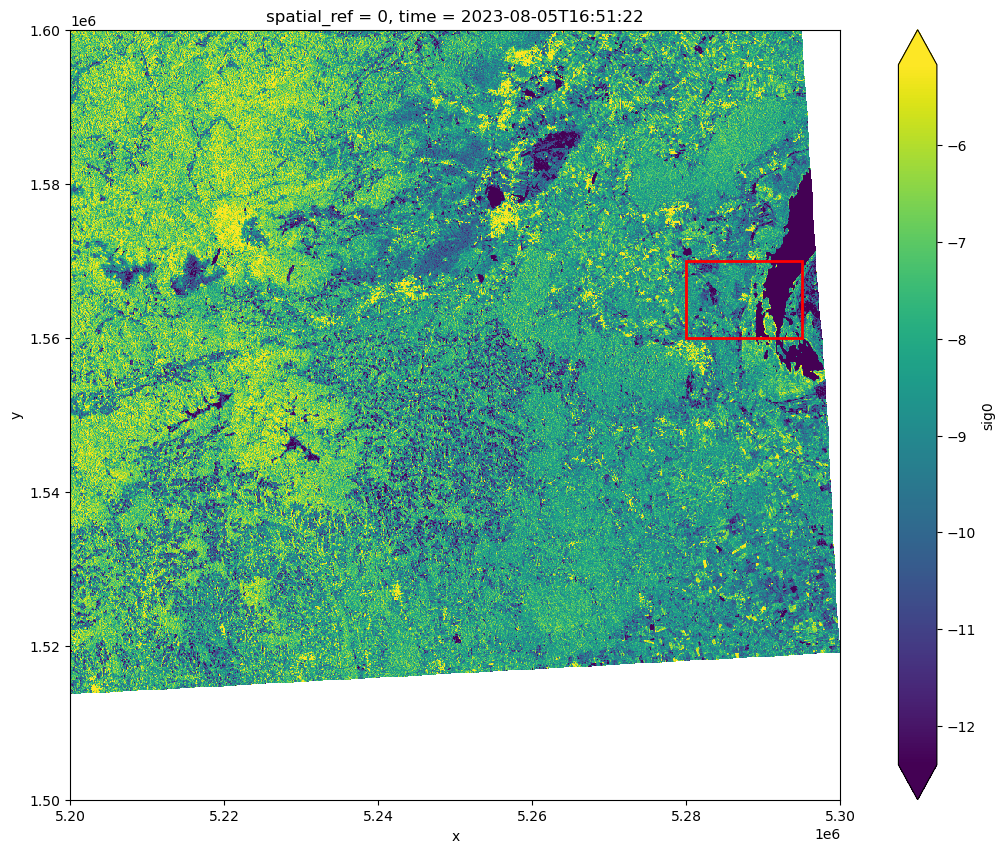

In [30]:
img = sig0_ds_large.isel(time=0) .coarsen(x=10, y=10, boundary='pad').median()

fig, ax = plt.subplots(figsize=(15, 10))

img.plot(ax=ax, robust=True, cmap="viridis")

rect = mpatches.Rectangle(
    (bounding_box['x_min'], bounding_box['y_min']),
    bounding_box['x_max'] - bounding_box['x_min'],
    bounding_box['y_max'] - bounding_box['y_min'],
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)
ax.set_aspect('equal')

plt.show()

In [16]:
sig0_ds = sig0_ds_large.sel(
    x=slice(bounding_box['x_min'], bounding_box['x_max']),
    y=slice(bounding_box['y_max'], bounding_box['y_min'])
)

<xarray.DataArray 'sig0' (time: 8, y: 1000, x: 1500)> Size: 96MB
dask.array<getitem, shape=(8, 1000, 1500), dtype=float64, chunksize=(1, 1, 1500), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 12kB 5.28e+06 5.28e+06 ... 5.295e+06 5.295e+06
  * y            (y) float64 8kB 1.57e+06 1.57e+06 ... 1.56e+06 1.56e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...

### Select the dates of interest

To create an RGB composite, we need to choose three distinct dates. It's recommended to select dates that are spaced out to capture noticeable changes over time. Pay attention to the season as well, as vegetation and other environmental factors often change significantly throughout the year.

Here the .sel method with nearest neighbor interpolation is used to choose the dates closest to the ones we specify.

In [18]:
# YOUR CODE HERE ----------------------------------------------------------
first = pd.Timestamp("2023-8-1")
second = pd.Timestamp("2023-9-15")
third = pd.Timestamp("2023-10-28")
# YOUR CODE HERE ----------------------------------------------------------

ds = sig0_ds.sel(time=[first, second, third], method='nearest')

### Map the backscatter to RGB values

To visualize backscatter data in RGB, we need to transform the data into values between 0 and 1 to match it to colors. The first step is to convert the backscattering values into linear scale so we can perform meaningful calculations. Now we can normalise the values to be between 0 and 1 using the following formula:
$$ 
sig0_{norm} = \frac{sig0 - sig0_{min}}{sig0_{98th} - sig0_{min}}
$$
We replaced the traditional maximum value with the 98th quantile in our normalization process to enhance robustness against outliers. Due to the nature of backscattering some sigma nought values get very high so taking the 98th quantile is important. The linear backscattering values are bounded by 0 so using for example the 2nd quantile is not necessary. After applying the formula, any values exceeding the 98th quantile will be greater than 1. We map these values to 1 to ensure they fit within our specified range."

In [19]:
def lin2db(val):
    return 10 * np.log10(val)


def db2lin(val):
    return 10 ** (val / 10)


def normalize(val, min, max):
    return (val - min) / (max - min)

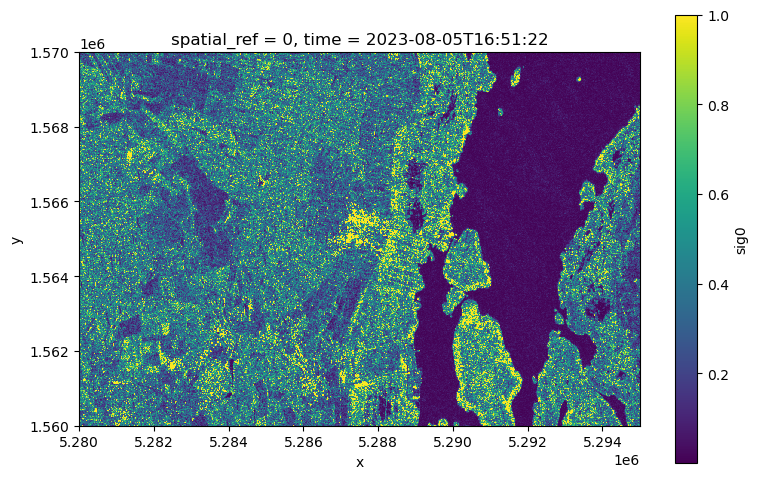

In [37]:
linear_ds = db2lin(ds).compute()

min_value = linear_ds.min().item()
max_robust = linear_ds.quantile(0.98).item()

normalized_ds = normalize(linear_ds, min_value, max_robust).clip(min=0, max=1)

fig, ax = plt.subplots(figsize=(8, 5))
normalized_ds.isel(time=0).plot.imshow()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### Plotting

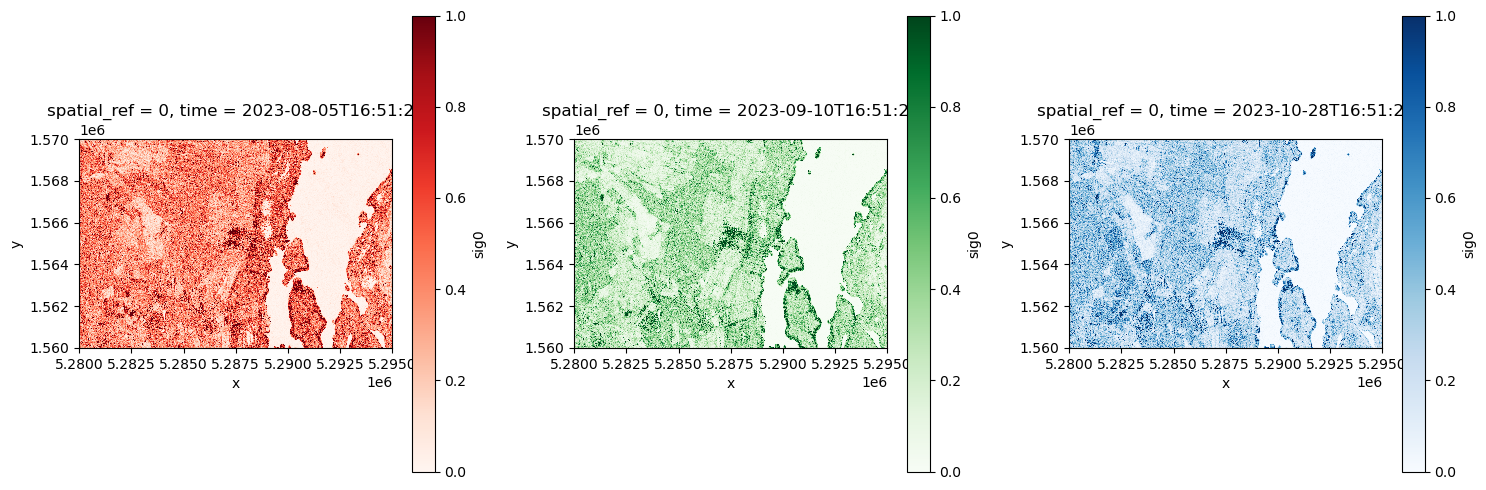

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

normalized_ds.isel(time=0).plot(ax=axes[0], cmap='Reds')
normalized_ds.isel(time=1).plot(ax=axes[1], cmap='Greens')
normalized_ds.isel(time=2).plot(ax=axes[2], cmap='Blues')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')


plt.tight_layout()
plt.show()

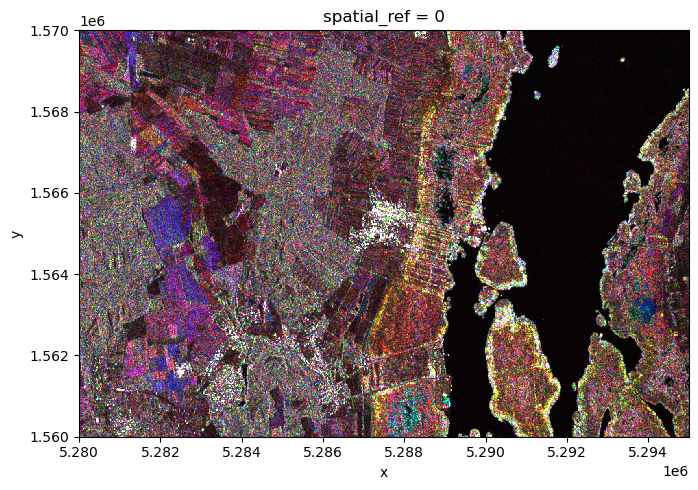

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))
normalized_ds.plot.imshow()
ax.set_aspect('equal')
plt.tight_layout()

plt.show()

### Define the exact task for the students: